### Imports and Definitions

In [1]:
from datetime import datetime
from gzip import open as gopen
from math import log10
from matplotlib import rcParams
from matplotlib.patches import Patch
from os.path import isfile
from pickle import load,dump
from random import shuffle
from scipy.stats import kendalltau
from seaborn import pointplot,set_context,set_style,stripplot,violinplot
from treeswift import read_tree_newick
import matplotlib.pyplot as plt
TN93THRESH = 0.015
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'

In [2]:
def p_to_star(p):
    if p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return ''

def avg(x):
    if len(x) == 0:
        return 0
    return sum(x)/len(x)

### Helper Function to Load FASTA

In [3]:
def read_FASTA(filename):
    seqs = {}
    name = None
    seq = ''
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        if len(l) == 0:
            continue
        if l[0] == '>':
            if name is not None:
                assert len(seq) != 0, "Malformed FASTA"
                seqs[name] = seq
            name = l[1:]
            assert name not in seqs, "Duplicate sequence ID: %s" % name
            seq = ''
        else:
            seq += l
    f.close()
    assert name is not None and len(seq) != 0, "Malformed FASTA"
    seqs[name] = seq
    return seqs

### Helper Function to Load tn93 Output as Distance Matrix

In [4]:
def read_tn93(filename):
    dm = dict()
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        u,v,d = l.split(',')
        if d == 'Distance':
            continue
        d = float(d)
        if u not in dm:
            dm[u] = dict()
        if v not in dm:
            dm[v] = dict()
        dm[u][v] = d; dm[v][u] = d
    return dm

### Helper Functions to Compute Cumulative Moving Average

In [5]:
# get the Cumulative Moving Average (CMA) over all indices
def cma(x):
    y = [x[0]]
    for i in range(1,len(x)):
        y.append(y[-1]+x[i])
    for i in range(len(y)):
        y[i] /= (i+1)
    return y

# helper function to compute the test statistic
def cma_test_stat(y,normalize=False):
    if normalize:
        sum_miny = sum(cma(sorted(x)))
        return (sum(y)-sum_miny)/(sum(cma(sorted(x,reverse=True)))-sum_miny) # AUC of CMA, normalized so min = 0 and max = 1
    else:
        return sum(y) # AUC of CMA

# returns (stat,p,cma_dist,stat_dist). "side" is "left" or "right"
def cma_test(x,side,bg_cma=None,bg_stat=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    y = cma(x)
    stat = cma_test_stat(y)
    if bg_cma is None or bg_stat is None:
        cma_dist = list(); stat_dist = list()
        for _ in range(it):
            tmp = x[:]; shuffle(tmp); tmp_cma = cma(tmp)
            cma_dist.append(tmp_cma)
            stat_dist.append(cma_test_stat(tmp_cma))
    else:
        cma_dist = bg_cma; stat_dist = bg_stat
    if side == 'right':
        p = sum(e >= stat for e in stat_dist)/len(stat_dist)
    elif side == 'left':
        p = sum(e <= stat for e in stat_dist)/len(stat_dist)
    return stat,p,cma_dist,stat_dist

### Helper Functions to Kendall’s Tau Test

In [6]:
# compute the Kendall's tau
def tau(om):
    t,p = kendalltau(om, list(range(len(om)-1,-1,-1))) # p is 2-sided
    return (t,p/2.)

# returns (stat,p,stat_dist)
def tau_test(om,side,bg=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    t,p = tau(om)
    if bg is None:
        tau_dist = list()
        for _ in range(it):
            tmp = om[:]; shuffle(tmp); tau_dist.append(tau(tmp)[0])
    else:
        tau_dist = bg
    #if side == 'right':
    #    p = sum(e >= t for e in tau_dist)/len(tau_dist)
    #elif side == 'left':
    #    p = sum(e <= t for e in tau_dist)/len(tau_dist)
    return t,p,tau_dist

### Helper Functions to Compute Pairwise Probability Test

In [7]:
DUMMY = '''
# compute the pairwise probability score
def pairprob(om):
    c = 0.; n = 0.; bins = dict()
    for i,e in reversed(list(enumerate(om))):
        if e not in bins:
            bins[e] = list()
        bins[e].append(i)
    vals = sorted(bins.keys(),reverse=True)
    for vi in range(len(vals)-1):
        for vj in range(vi+1,len(vals)):
            n += len(bins[vals[vi]])*len(bins[vals[vj]])
            for i in bins[vals[vi]]:
                for j in bins[vals[vj]]:
                    if i < j:
                        c += 1
    return c/n

# helper function to compute the test statistic
def pairprob_stat(om):
    return pairprob(om)

# returns (stat,p,stat_dist)
def pairprob_test(om,side,bg=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    pp = pairprob_stat(om)
    if bg is None:
        pp_dist = list()
        for _ in range(it):
            tmp = om[:]; shuffle(tmp); pp_dist.append(pairprob_stat(tmp))
    else:
        pp_dist = bg
    if side == 'right':
        p = sum(e >= pp for e in pp_dist)/len(pp_dist)
    elif side == 'left':
        p = sum(e <= pp for e in pp_dist)/len(pp_dist)
    return pp,p,pp_dist
'''

### Helper Functions to Compute Weighted Pairwise Probability Test

In [8]:
DUMMY = '''
# compute the weighted pairwise probability score
def pairprob_weighted(om):
    c = 0.; bins = dict()
    for i,e in reversed(list(enumerate(om))):
        if e not in bins:
            bins[e] = list()
        bins[e].append(i)
    vals = sorted(bins.keys(),reverse=True)
    for vi in range(len(vals)-1):
        for vj in range(vi+1,len(vals)):
            for i in bins[vals[vi]]:
                for j in bins[vals[vj]]:
                    c += max(0,j-i)
    return c

# helper function to compute the test statistic
def pairprob_weighted_stat(om):
    maxstat = pairprob_weighted(sorted(om,reverse=True))
    return pairprob_weighted(om)/maxstat

# returns (stat,p,stat_dist)
def pairprob_weighted_test(om,side,bg=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    pp = pairprob_weighted_stat(om)
    if bg is None:
        pp_dist = list()
        for _ in range(it):
            tmp = om[:]; shuffle(tmp); pp_dist.append(pairprob_weighted_stat(tmp))
    else:
        pp_dist = bg
    if side == 'right':
        p = sum(e >= pp for e in pp_dist)/len(pp_dist)
    elif side == 'left':
        p = sum(e <= pp for e in pp_dist)/len(pp_dist)
    return pp,p,pp_dist
'''

### Helper Functions to Compute Split Pairwise Probability Test

In [9]:
DUMMY = '''
# compute the split pairwise probability score
def pairprob_split(om,x):
    num_top = int(len(om)*x); c = 0.; bins = dict(); n = 0.
    for i in range(num_top):
        for j in range(num_top,len(om)):
            if om[i] != om[j]:
                n += 1
            if om[i] > om[j]:
                c += 1
    return c/n

# helper function to compute the test statistic
def pairprob_split_stat(om,x):
    #maxstat = pairprob_split(sorted(om,reverse=True),x)
    return pairprob_split(om,x)#/maxstat

# returns (stat,p,stat_dist)
def pairprob_split_test(om,x,side,bg=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    pp = pairprob_split_stat(om,x)
    if bg is None:
        pp_dist = list()
        for _ in range(it):
            tmp = om[:]; shuffle(tmp); pp_dist.append(pairprob_split_stat(tmp,x))
    else:
        pp_dist = bg
    if side == 'right':
        p = sum(e >= pp for e in pp_dist)/len(pp_dist)
    elif side == 'left':
        p = sum(e <= pp for e in pp_dist)/len(pp_dist)
    return pp,p,pp_dist
'''

# Real Data

### Load Data

In [10]:
data = {
    'seqs': read_FASTA('../real_data/sd.full.aln.gz'),
    'tn93': read_tn93('../real_data/sd.full.tn93.csv.gz'),
    'time': {t:{l.decode().strip().split()[0]:int(l.decode().strip().split()[1]) for l in gopen('../real_data/sd.time.%s.tsv.gz'%t)} for t in ['sample','diagnosis','infection']},
    'proact': {n:{t:{s:{m:gopen('../real_data/sd.%s.%s.mv.proact.%s.%s.txt.gz'%(n,t,s,m)).read().decode().strip().splitlines() for m in ['feedback','oldmode']} for s in ['sample']} for t in ['ft','iq']} for n in ['10','20','30','40','50','60','70','80','90','full']},
    'hivtrace': {n:gopen('../real_data/sd.%s.hivtrace.txt.gz'%n).read().decode().strip().splitlines() for n in ['10','20','30','40','50','60','70','80','90','full']}
}
metareal = {
    'label': {
        'ft': 'FastTree',
        'iq': 'IQ-TREE',
        'feedback': 'ProACT',
        'oldmode': 'ProACT (No Feedback)',
        'max': 'Optimal',
        'bg': 'Null Distribution',
        'hivtrace': 'GD + Cluster Growth'
    },
    'color': {
        'ft': 'green',
        'iq': 'blue',
        'max': 'black',
        'bg': 'lightgrey',
        'hivtrace': 'orange'
    }
}
DATE = {per:max(datetime.strptime(l.split('_')[1], '%m-%d-%y') for l in data['proact'][per]['iq']['sample']['feedback']) for per in data['proact']}

## Metric: 1/(average time between me and HIV-TRACE link)

### Cumulative Moving Average (CMA) Test

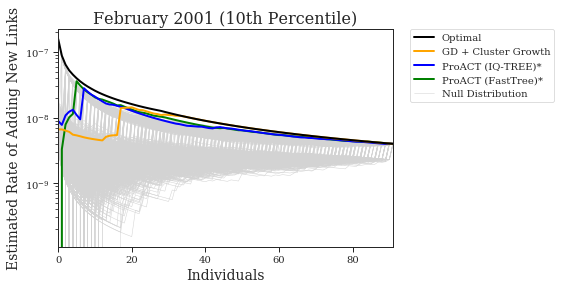

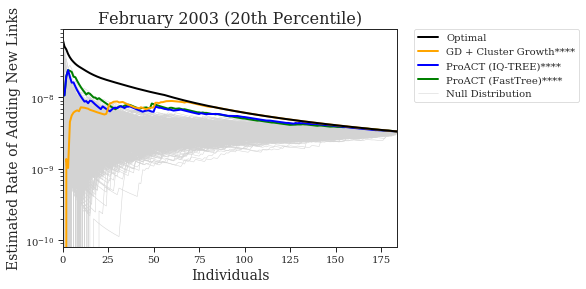

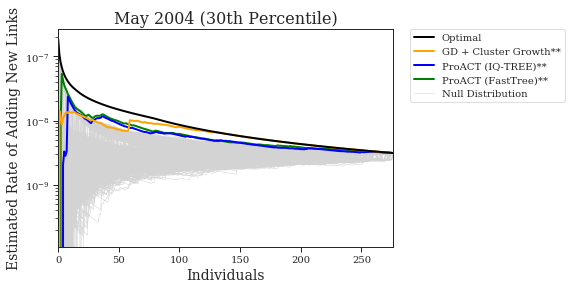

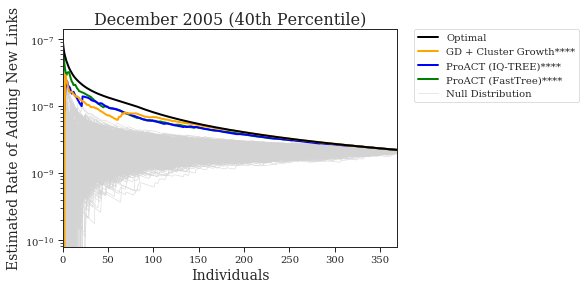

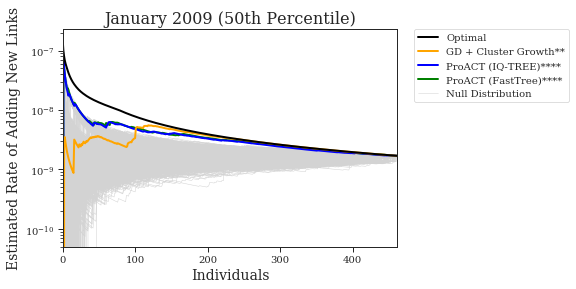

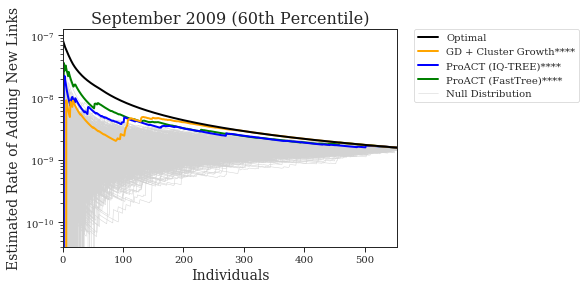

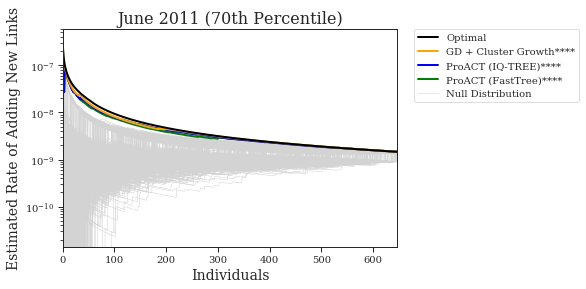

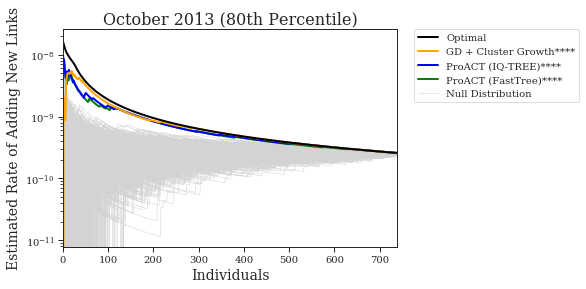

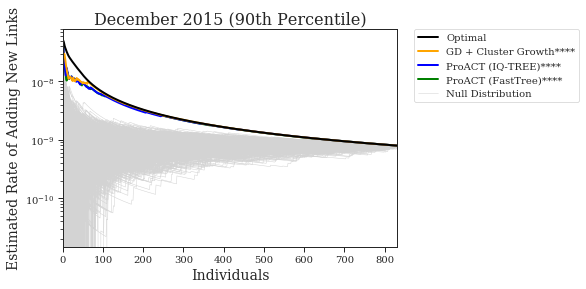

In [11]:
IT = 10000
for per in ['10','20','30','40','50','60','70','80','90']:
    END = max(int(l.split('_')[-1]) for l in data['proact'][per]['ft']['sample']['feedback'])
    for s in ['sample']:
        fig = plt.figure()
        cma_dist = None; stat_dist = None
        pronew_y = dict()
        pronew_pstr = dict()
        for t in ['ft','iq','hivtrace']:
            if t in {'ft','iq'}:
                currdata = data['proact'][per][t][s]['feedback']
            else:
                currdata = data['hivtrace'][per]
            x = list(range(len(currdata)))
            pronew = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in currdata]
            pronew = [0 if e == 0 else 1./e for e in pronew]
            pronew_y[t] = cma(pronew)
            pronew_stat,pronew_p,cma_dist,stat_dist = cma_test(pronew,'right',bg_cma=cma_dist,bg_stat=stat_dist,it=IT)
            pronew_pstr[t] = "{:.{}f}".format(pronew_p,int(log10(IT)))
            opt_y = cma(sorted(pronew,reverse=True))
        plt.plot(x,cma_dist[0],color=metareal['color']['bg'],linewidth=0.5,label=metareal['label']['bg'])
        for bg in cma_dist[1:min(len(cma_dist),1000)]: # background distribution
                plt.plot(x,bg,color=metareal['color']['bg'],linewidth=0.5)
        for t in ['ft','iq','hivtrace']:
            if t in {'ft','iq'}:
                currlabel = "%s (%s)%s"%(metareal['label']['feedback'],metareal['label'][t],p_to_star(float(pronew_pstr[t])))
            else:
                currlabel = "%s%s"%(metareal['label']['hivtrace'],p_to_star(float(pronew_pstr[t])))
            plt.plot(x,pronew_y[t],color=metareal['color'][t],linewidth=2,label=currlabel) # ProACT feedback result
        plt.plot(x,opt_y,color=metareal['color']['max'],linewidth=2,label=metareal['label']['max']) # max possible
        plt.xlim(xmin=0,xmax=max(x))
        plt.gca().set_yscale('log')
        handles,labels = fig.gca().get_legend_handles_labels()
        plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.title("%s (%sth Percentile)"%(DATE[per].strftime('%B %Y'),per))
        plt.xlabel("Individuals")
        plt.ylabel("Estimated Rate of Adding New Links")
        fig.savefig('figs/results_cmatest_p%s.pdf'%per, format='pdf', bbox_inches='tight')

### Kendall's Tau Test

ProACT, FastTree
10-th Percentile: 0.302550 (p = 7e-05)
20-th Percentile: 0.218593 (p = 5e-05)
30-th Percentile: 0.183422 (p = 3e-05)
40-th Percentile: 0.347001 (p = 4e-18)
50-th Percentile: 0.228272 (p = 2e-10)
60-th Percentile: 0.156936 (p = 2e-06)
70-th Percentile: 0.224391 (p = 6e-13)
80-th Percentile: 0.165763 (p = 1e-08)
90-th Percentile: 0.269084 (p = 3e-22)

ProACT, IQ-TREE
10-th Percentile: 0.234517 (p = 2e-03)
20-th Percentile: 0.246720 (p = 5e-06)
30-th Percentile: 0.129759 (p = 2e-03)
40-th Percentile: 0.336309 (p = 4e-17)
50-th Percentile: 0.194791 (p = 5e-08)
60-th Percentile: 0.145248 (p = 8e-06)
70-th Percentile: 0.233279 (p = 7e-14)
80-th Percentile: 0.180871 (p = 6e-10)
90-th Percentile: 0.273222 (p = 7e-23)

GD + Cluster Growth
10-th Percentile: 0.546553 (p = 4e-12)
20-th Percentile: 0.507665 (p = 6e-20)
30-th Percentile: 0.516744 (p = 1e-29)
40-th Percentile: 0.444724 (p = 1e-28)
50-th Percentile: 0.347589 (p = 8e-22)
60-th Percentile: 0.234149 (p = 2e-12)
70-th Per

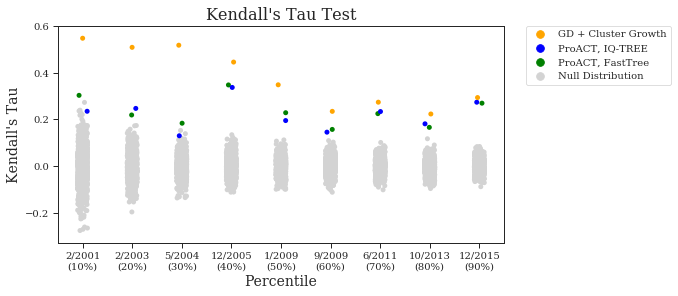

In [12]:
IT = 1000; BG = dict()
ymin = None; ymax = None #ymin = -1; ymax = 1
for s in ['sample']:
    fig = plt.figure(figsize=(8,4))
    x = list(); y = list(); hue = list(); pal = list(); tmp = list(); pal = [metareal['color']['bg']]
    for m in ['feedback']:
        for t in ['ft','iq','hivtrace']:
            if t in {'ft','iq'}:
                label = "%s, %s"%(metareal['label'][m],metareal['label'][t])
            else:
                label = metareal['label'][t]
            print(label)
            for per in ['10','20','30','40','50','60','70','80','90']:
                if per not in BG:
                    BG[per] = None
                if t in {'ft','iq'}:
                    currdata = data['proact'][per][t]['sample']['feedback']
                else:
                    currdata = data['hivtrace'][per]
                END = max(int(l.split('_')[-1]) for l in currdata)
                val = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in currdata]
                val = [0 if e == 0 else 1./e for e in val]
                taustat,p,tau_dist = tau_test(val,'right',bg=BG[per],it=IT); BG[per] = tau_dist
                print("%s-th Percentile: %f (p = %s)" % (per,taustat,format(p,'.0e')))
                tmp.append((per,taustat,label,metareal['color'][t]))
            print()
    for per in BG:
        for bg in BG[per]:
            #x.append(per) # plot percentiles on x-axis
            #x.append(YEAR[per]) # plot years on x-axis
            x.append("%s\n(%s%%)"%(DATE[per].strftime('%-m/%Y'),per))
            y.append(bg); hue.append(metareal['label']['bg'])
    for per,taustat,h,c in tmp:
        #x.append(per) # plot percentiles on x-axis
        #x.append(YEAR[per]) # plot years on x-axis
        x.append("%s\n(%s%%)"%(DATE[per].strftime('%-m/%Y'),per))
        y.append(taustat); hue.append(h)
        if c not in pal:
            pal.append(c)
    stripplot(x=x,y=y,hue=hue,palette=pal,jitter=True)
    handles,labels = fig.gca().get_legend_handles_labels()
    plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title("Kendall's Tau Test")
    plt.xlabel("Percentile")
    plt.ylabel("Kendall's Tau")
    fig.savefig('figs/results_tautest.pdf', format='pdf', bbox_inches='tight')

### Pairwise Probability Test

In [13]:
DUMMY = '''
IT = 1000; ymin = 0; ymax = 1; BG = dict()
for s in ['sample']:
    fig = plt.figure()
    x = list(); y = list(); hue = list(); pal = list(); tmp = list(); pal = [metareal['color']['bg']]
    for m in ['feedback']:
        for t in ['ft','iq','hivtrace']:
            print("%s, %s"%(metareal['label'][m],metareal['label'][t]))
            for per in ['10','20','30','40','50','60','70','80','90']:
                if per not in BG:
                    BG[per] = None
                if t in {'ft','iq'}:
                    currdata = data['proact'][per]['ft']['sample']['feedback']
                else:
                    currdata = data['hivtrace'][per]
                END = max(int(l.split('_')[-1]) for l in currdata)
                val = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in currdata]
                val = [0 if e == 0 else 1./e for e in val]
                pp,p,pp_dist = pairprob_test(val,'right',bg=BG[per],it=IT); BG[per] = pp_dist
                print("%s-th Percentile: %f" % (per,p))
                tmp.append((per,pp,"%s (%s)"%(metareal['label']['feedback'],metareal['label'][t]),metareal['color'][t]))
            print()
    for per in BG:
        for bg in BG[per]:
            x.append(per); y.append(bg); hue.append(metareal['label']['bg'])
    for per,pp,h,c in tmp:
        x.append(per); y.append(pp); hue.append(h)
        if c not in pal:
            pal.append(c)
    stripplot(x=x,y=y,hue=hue,palette=pal,jitter=True)
    handles,labels = fig.gca().get_legend_handles_labels()
    plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title("Pairwise Probability Test")
    plt.xlabel("Percentile")
    plt.ylabel("Pairwise Probability")
    fig.savefig('figs/results_pairprobtest.pdf', format='pdf', bbox_inches='tight')
'''

### Weighted Pairwise Probability Test

In [14]:
DUMMY = '''
IT = 100; ymin = 0; ymax = 1; BG = dict()
for s in ['sample']:
    fig = plt.figure()
    x = list(); y = list(); hue = list(); pal = list(); tmp = list(); pal = [metareal['color']['bg']]
    for m in ['feedback']:
        for t in ['ft','iq','hivtrace']:
            print("%s, %s"%(metareal['label'][m],metareal['label'][t]))
            for per in ['10','20','30','40','50','60','70','80','90']:
                if per not in BG:
                    BG[per] = None
                if t in {'ft','iq'}:
                    currdata = data['proact'][per]['ft']['sample']['feedback']
                else:
                    currdata = data['hivtrace'][per]
                END = max(int(l.split('_')[-1]) for l in currdata)
                val = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in currdata]
                val = [0 if e == 0 else 1./e for e in val]
                pp,p,pp_dist = pairprob_weighted_test(val,'right',bg=BG[per],it=IT); BG[per] = pp_dist
                print("%s-th Percentile: %f" % (per,p))
                tmp.append((per,pp,r"%s (%s)"%(metareal['label']['feedback'],metareal['label'][t]),metareal['color'][t]))
            print()
    for per in BG:
        for bg in BG[per]:
            x.append(per); y.append(bg); hue.append(metareal['label']['bg'])
    for per,pp,h,c in tmp:
        x.append(per); y.append(pp); hue.append(h)
        if c not in pal:
            pal.append(c)
    stripplot(x=x,y=y,hue=hue,palette=pal,jitter=True)
    handles,labels = fig.gca().get_legend_handles_labels()
    plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title("Weighted Pairwise Probability Test")
    plt.xlabel("Percentile")
    plt.ylabel("Weighted Pairwise Probability")
    fig.savefig('figs/results_weightedpairprobtest.pdf', format='pdf', bbox_inches='tight')
'''

### Split Pairwise Probability Test

In [15]:
DUMMY = '''
IT = 100; ymin = 0; ymax = 1; BG = dict()
for s in ['sample']:
    for cutoff in [10,20,30,40,50,60,70,80,90]:
        fig = plt.figure()
        x = list(); y = list(); hue = list(); pal = list(); tmp = list(); pal = [metareal['color']['bg']]
        for m in ['feedback']:
            for t in ['ft','iq','hivtrace']:
                print("%s, %s"%(metareal['label'][m],metareal['label'][t]))
                for per in ['10','20','30','40','50','60','70','80','90']:
                    if per not in BG:
                        BG[per] = None
                    if t in {'ft','iq'}:
                        currdata = data['proact'][per]['ft']['sample']['feedback']
                    else:
                        currdata = data['hivtrace'][per]
                    END = max(int(l.split('_')[-1]) for l in currdata)
                    val = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in currdata]
                    val = [0 if e == 0 else 1./e for e in val]
                    pp,p,pp_dist = pairprob_split_test(val,cutoff/100.,'right',bg=BG[per],it=IT); BG[per] = pp_dist
                    print("%s-th Percentile: %f" % (per,p))
                    tmp.append((per,pp,r"%s (%s)"%(metareal['label']['feedback'],metareal['label'][t]),metareal['color'][t]))
                print()
        for per in BG:
            for bg in BG[per]:
                x.append(per); y.append(bg); hue.append(metareal['label']['bg'])
        for per,pp,h,c in tmp:
            x.append(per); y.append(pp); hue.append(h)
            if c not in pal:
                pal.append(c)
        stripplot(x=x,y=y,hue=hue,palette=pal,jitter=True)
        handles,labels = fig.gca().get_legend_handles_labels()
        plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylim(ymin=ymin,ymax=ymax)
        plt.title(r"Split Pairwise Probability Test $(x=%d)$"%cutoff)
        plt.xlabel("Percentile")
        plt.ylabel("Split Pairwise Probability")
        fig.savefig('figs/results_splitpairprobtest_%d.pdf'%cutoff, format='pdf', bbox_inches='tight')
'''

# Simulated Data

### Load Data

In [16]:
eff = load(gopen('../simulations/efficacy.pkl.gz'))
metasim = {
    'label': {
        'expected': 'Population Mean',
        'optimal': 'Optimal',
        'hivtrace': 'GD + Cluster Growth',
        'proact.feedback.true': 'ProACT (True Trees)',
        'proact.feedback.ftmv': 'ProACT (FastTree)',
        'proact.oldmode.true': 'ProACT (No Feedback, True Trees)',
        'proact.oldmode.ftmv': 'ProACT (No Feedback, FastTree)',
        'SAMPLE-END_ARTRATE-1': r'ART Rate 1 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-2': r'ART Rate 2 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-4': r'ART Rate 4 year$^{-1}$ (Sample End)',
        'SAMPLE-FIRSTART_ARTRATE-0.5': r'ART Rate 0.5 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-1': r'ART Rate 1 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-2': r'ART Rate 2 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-4': r'ART Rate 4 year$^{-1}$',
        'SAMPLE-FIRSTART_EXPDEGREE-20': 'Expected Degree 20',
        'SAMPLE-FIRSTART_EXPDEGREE-30': 'Expected Degree 30',
    },
    'color': {
        'expected': 'lightgrey',
        'optimal': 'black',
        'hivtrace': 'orange',
        'proact.feedback.true': 'lightblue',
        'proact.feedback.ftmv': 'blue',
        'proact.oldmode.true': 'lightgreen',
        'proact.oldmode.ftmv': 'green',
        'SAMPLE-FIRSTART_ARTRATE-1': 'lightblue',
        'SAMPLE-FIRSTART_ARTRATE-2': 'blue',
        'SAMPLE-FIRSTART_ARTRATE-4': 'darkblue',
        'SAMPLE-END_ARTRATE-1': 'lightgreen',
        'SAMPLE-END_ARTRATE-2': 'green',
        'SAMPLE-END_ARTRATE-4': 'darkgreen',
        'SAMPLE-FIRSTART_EXPDEGREE-20': 'orange',
        'SAMPLE-FIRSTART_EXPDEGREE-30': 'red',
    },
    'linestyle': {
        'expected': '--',
        'optimal': '--',
        'hivtrace': '-.',
        'proact.feedback.true': '-',
        'proact.feedback.ftmv': '-',
        'proact.oldmode.true': '-',
        'proact.oldmode.ftmv': '-',
        'SAMPLE-FIRSTART_ARTRATE-1': '-',
        'SAMPLE-FIRSTART_ARTRATE-2': '-',
        'SAMPLE-FIRSTART_ARTRATE-4': '-',
        'SAMPLE-END_ARTRATE-1': '-',
        'SAMPLE-END_ARTRATE-2': '-',
        'SAMPLE-END_ARTRATE-4': '-',
        'SAMPLE-FIRSTART_EXPDEGREE-20': '-',
        'SAMPLE-FIRSTART_EXPDEGREE-30': '-',
    }
}

## Metric: Number of Infections After Year 9

### Comparing Methods

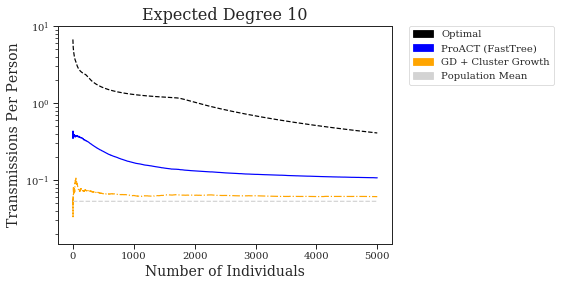

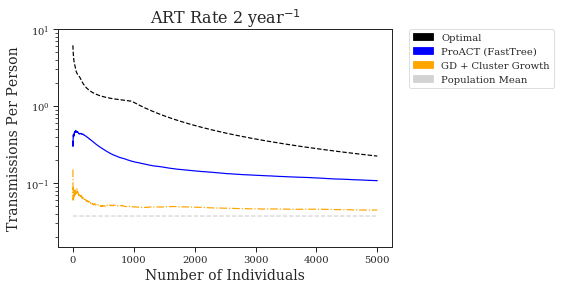

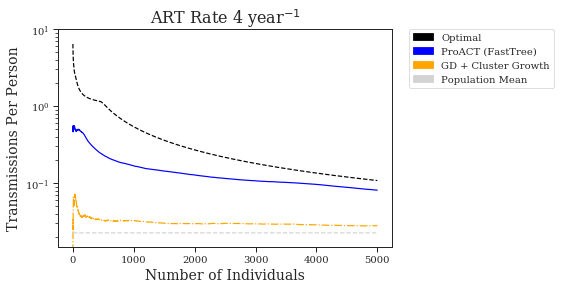

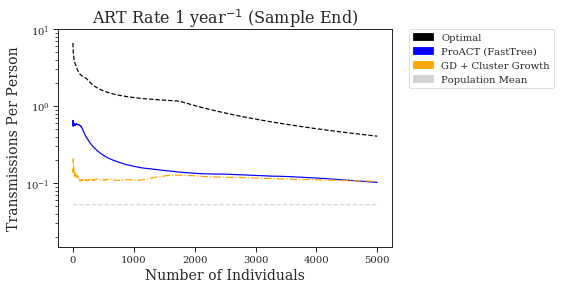

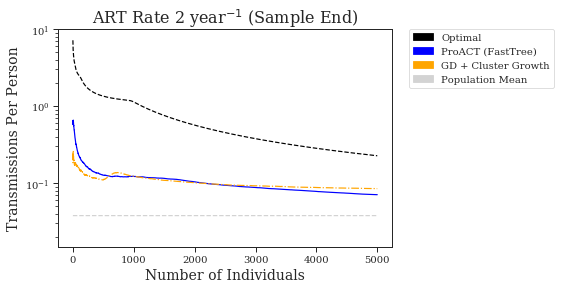

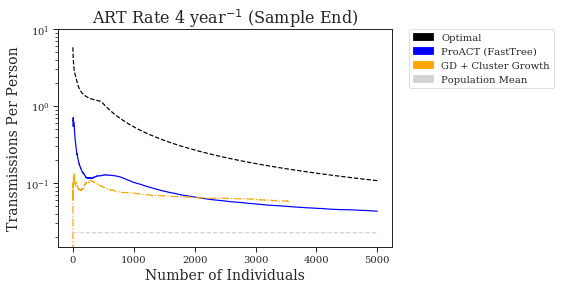

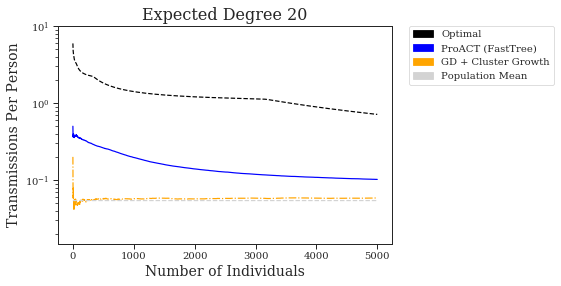

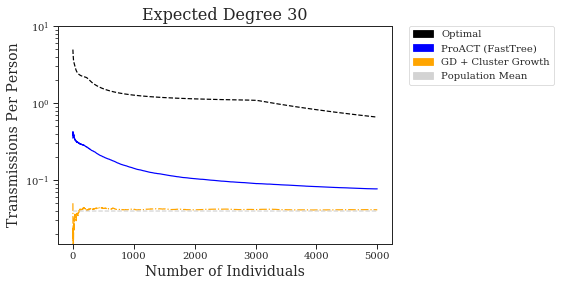

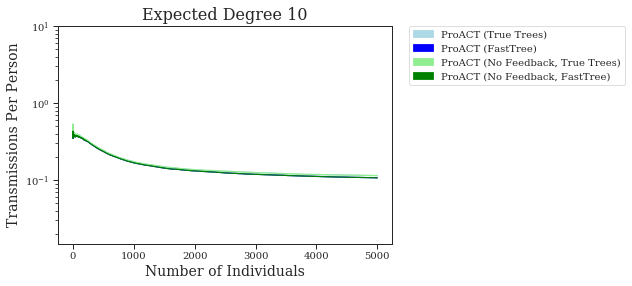

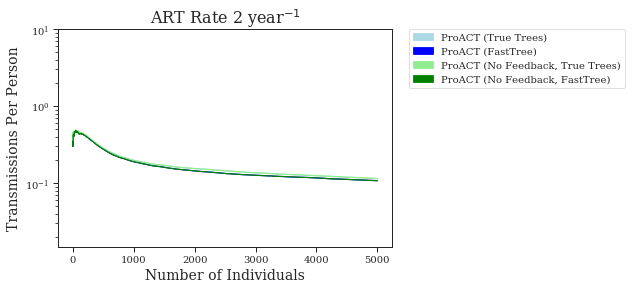

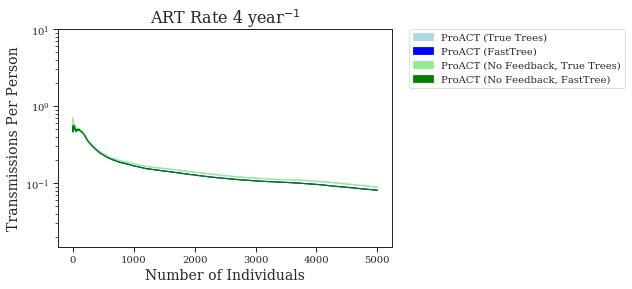

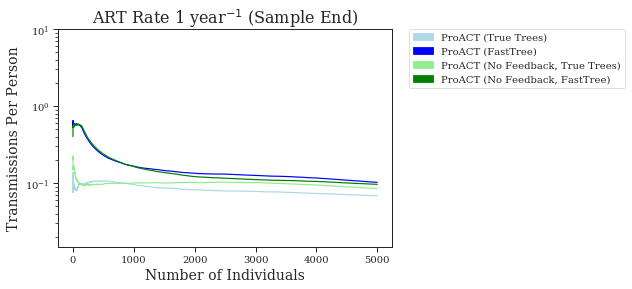

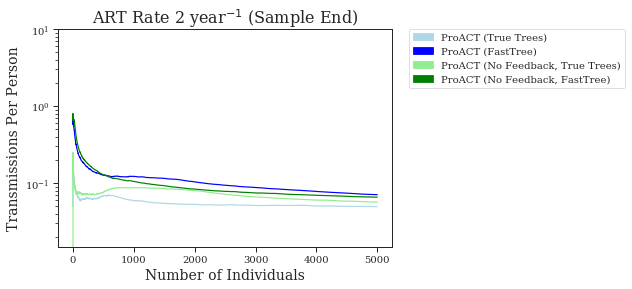

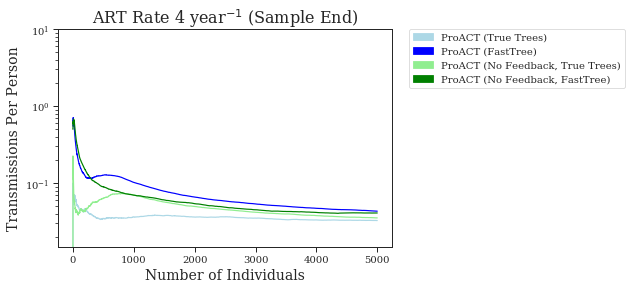

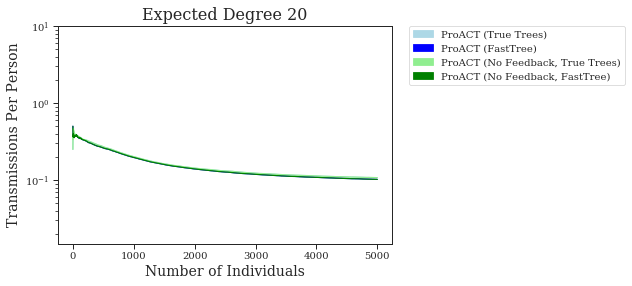

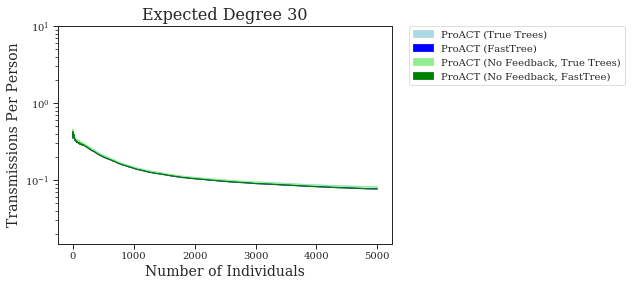

In [17]:
Ms = {
    'main': ['optimal','proact.feedback.ftmv','hivtrace','expected'],
    'sup': ['proact.feedback.true','proact.feedback.ftmv','proact.oldmode.true','proact.oldmode.ftmv'],
}
Ks = ['SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-END_ARTRATE-1','SAMPLE-END_ARTRATE-2','SAMPLE-END_ARTRATE-4','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30']
ymin = 1.5*(10**-2); ymax = 10
for part,M in Ms.items():
    handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in M]
    for K in Ks:
        fig = plt.figure()
        for m in M:
            x = list(range(len(eff[m][K][0])))
            cmas = [cma(l) for l in eff[m][K]]
            y = [avg([c[i] for c in cmas if i < len(c)]) for i in x]
            plt.plot(x, y, color=metasim['color'][m], linestyle=metasim['linestyle'][m], label=metasim['label'][m])
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.gca().set_yscale('log')
        plt.ylim(ymin=ymin,ymax=ymax)
        plt.title(metasim['label'][K])
        plt.xlabel("Number of Individuals")
        plt.ylabel("Transmissions Per Person")
        fig.savefig('figs/results_efficacy_%s_%s.pdf'%(K,part), format='pdf', bbox_inches='tight')
        if K == 'SAMPLE-FIRSTART_ARTRATE-1':
            plt.title("Expected Degree 10")
            fig.savefig('figs/results_efficacy_SAMPLE-FIRSTART_EXPDEGREE-10_%s.pdf'%part, format='pdf', bbox_inches='tight')

### Comparing Model Conditions

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


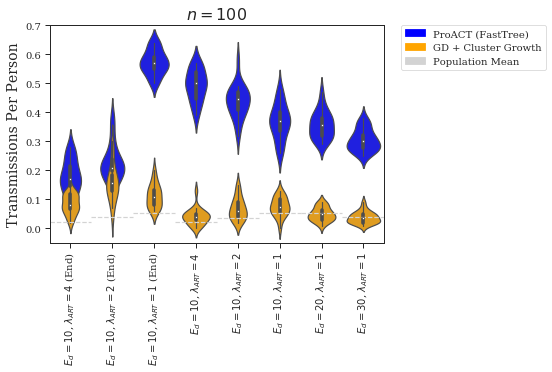

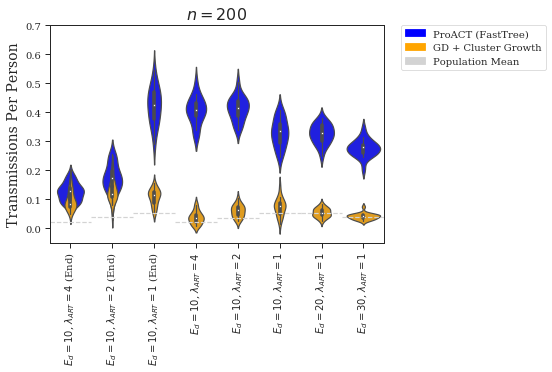

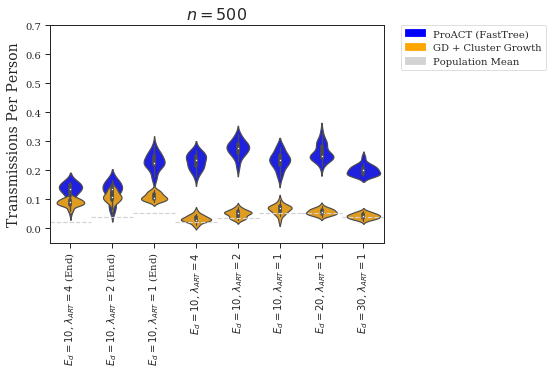

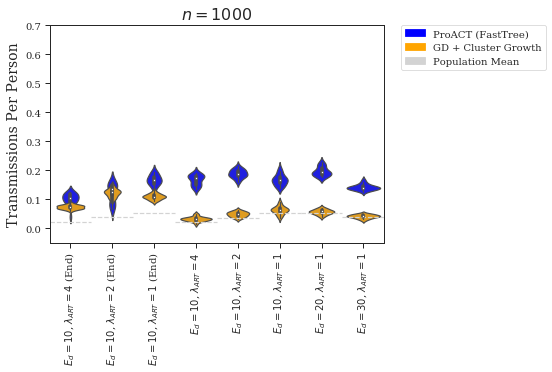

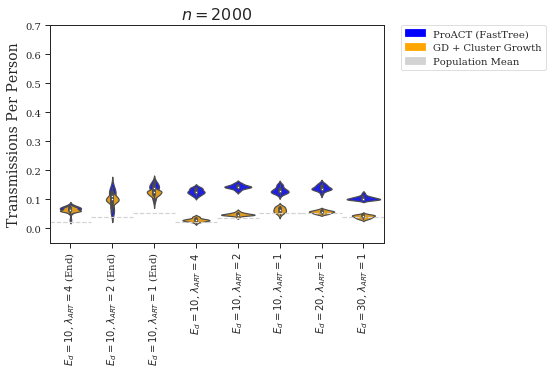

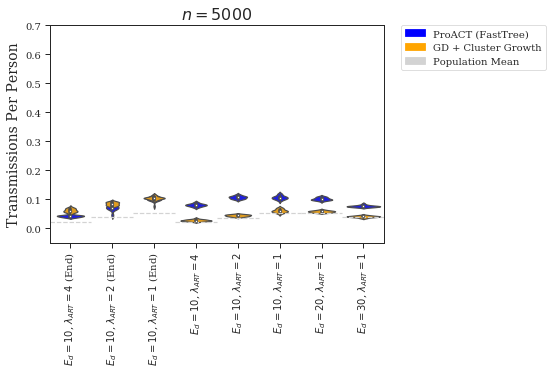

In [18]:
Ks = ['SAMPLE-END_ARTRATE-4','SAMPLE-END_ARTRATE-2','SAMPLE-END_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30']
tr = {
    'SAMPLE-FIRSTART_ARTRATE-1': r'$E_{d}=10$, $\lambda_{ART}=1$',
    'SAMPLE-FIRSTART_ARTRATE-2': r'$E_{d}=10$, $\lambda_{ART}=2$',
    'SAMPLE-FIRSTART_ARTRATE-4': r'$E_{d}=10$, $\lambda_{ART}=4$',
    'SAMPLE-FIRSTART_EXPDEGREE-20': r'$E_{d}=20$, $\lambda_{ART}=1$',
    'SAMPLE-FIRSTART_EXPDEGREE-30': r'$E_{d}=30$, $\lambda_{ART}=1$',
    'SAMPLE-END_ARTRATE-1': r'$E_{d}=10$, $\lambda_{ART}=1$ (End)',
    'SAMPLE-END_ARTRATE-2': r'$E_{d}=10$, $\lambda_{ART}=2$ (End)',
    'SAMPLE-END_ARTRATE-4': r'$E_{d}=10$, $\lambda_{ART}=4$ (End)',
}
Ms = ['proact.feedback.ftmv','hivtrace']
Ns = [100,200,500,1000,2000,5000]
handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in Ms+['expected']]
ymin = -0.05; ymax = 0.7
for n in Ns:
    fig = plt.figure()
    for m in Ms:
        x = list(); y = list()
        for K in Ks:
            y += [avg(l[:n]) for l in eff[m][K]]; x += [tr[K]]*len(eff[m][K])
        violinplot(x=x, y=y, color=metasim['color'][m], labels=metasim['label'][m])
    xlim = plt.xlim()
    for m in ['expected']:#,'optimal']: # plot expected and optimal lines
        for i,K in enumerate(Ks):
            plt.plot([i-0.5,i+0.5], [avg([avg(l) for l in eff[m][K]])]*2, linestyle=metasim['linestyle'][m], color=metasim['color'][m])
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(xlim)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title(r"$n=%d$" % n)
    plt.ylabel("Transmissions Per Person")
    plt.xticks(rotation=90)
    fig.savefig('figs/results_efficacy_n%d.pdf'%n, format='pdf', bbox_inches='tight')